## Classifying MFCC data with 1D-Convolutional Neural Network

#### Keywords
Sequence Classification, MFCC, 1DConv, Class Weight, Data Augmentation, Magnitude Warping, Window Slicing, Time Masking, Channel Masking

### **Contents**
 1. Short and friendly introduction 
 2. Loading dataset
 3. Preprocessing
 4. Conv1D
 5. Synthetic data
     - Magnitude Warping
     - Window Slicing
     - Time masking
     - Channel masking
     - Combining all mentioned strategies

### 1. Short and friendly introduction
Hello and welcome to Sequence(MFCC) Classification with Conv1D! This is one of the Machine Learning projects I did during my study. The data and some ideas were taken from my previous projects to recreate this repo. Enjoy! :))

**Dataset**
- X: MFCC (Mel-frequency Cepstral Coefficients)
    - dim: (94824, 99, 13)
- y: labels
    - dim: (94824, )

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
from tools import *

### 2. Loading dataset

In [ ]:
folder_dir = 'dataset'
X_dir = 'MFCC.npy'
y_dir = 'labels.npy'
X = LOAD_FROM_DRIVE(folder_dir, X_dir)
y = LOAD_FROM_DRIVE(folder_dir, y_dir)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                y_val,
                                                test_size=0.5,
                                                random_state=123)
print("x_train :", X_train.shape)
print("y_train :", y_train.shape)
print("x_val   :", X_val.shape)
print("y_val   :" , y_val.shape)
print("x_test  :", X_test.shape)
print("y_test  :", y_test.shape)

x_train : (66376,)
y_train : (66376,)
x_val   : (14224,)
y_val   : (14224,)
x_test  : (14224,)
y_test  : (14224,)


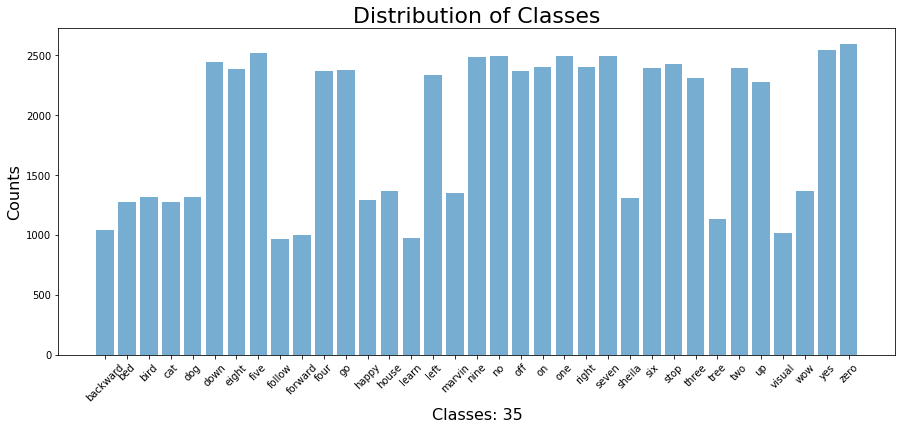

In [ ]:
plot_class_distribution(y_train, figsize=(15, 6))

### 3. Preprocessing

In [ ]:
# create a dictionary for classes
class_dict = get_class_dict(y_test)

# remove all sequence with length >= n 
mask_out = remove_too_short(X_train, shorter_than=85)
X_train_ = np.asarray([pad_sequence(i) for i in X_train[mask_out]])
y_train_ = np.asarray(label_vectorize(y_train[mask_out], class_dict, one_hot=False))

# pad sequences (x)
X_val_ = np.asarray([pad_sequence(i) for i in X_val])
X_test_ = np.asarray([pad_sequence(i) for i in X_test])

# vectorize (y)
y_val_ = np.asarray(label_vectorize(y_val, class_dict, one_hot=False))
y_test_ = np.asarray(label_vectorize(y_test, class_dict, one_hot=False))

In [ ]:
print(f"x_train : {X_train.shape}   ==> {X_train_.shape}")
print(f"y_train : {y_train.shape}   ==> {y_train_.shape}")
print()
print(f"x_val   : {X_val.shape}   ==> {X_val_.shape}")
print(f"y_val   : {y_val.shape}   ==> {y_val_.shape}")
print()
print(f"x_test  : {X_test.shape}   ==> {X_test_.shape}")
print(f"y_test  : {y_test.shape}   ==> {y_test_.shape}")

x_train : (66376,)   ==> (62309, 99, 13)
y_train : (66376,)   ==> (62309,)

x_val   : (14224,)   ==> (14224, 99, 13)
y_val   : (14224,)   ==> (14224,)

x_test  : (14224,)   ==> (14224, 99, 13)
y_test  : (14224,)   ==> (14224,)


### 4. Conv1D

This model has already been fine-tuned (slightly).
I attempt to use the performance of 'Model 1' as the baseline, and try to improve by applying several combinations of techniques.

In [ ]:
model_1 = define_model()
model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

In [ ]:
my_class_weights = get_class_weights(y_train_, input_type='categorical')

In [ ]:
loss_rec1 = model_1.fit(X_train_, y_train_,
                       batch_size=128,
                       epochs=15,
                       verbose=1,
                       class_weight=my_class_weights, 
                       validation_data=(X_val_, y_val_))

Train on 62309 samples, validate on 14224 samples
Epoch 1/15
62309/62309 [==============================] - 17s 278us/sample - loss: 1.2528 - acc: 0.6478 - val_loss: 0.5235 - val_acc: 0.8459
Epoch 2/15
62309/62309 [==============================] - 16s 252us/sample - loss: 0.5239 - acc: 0.8484 - val_loss: 0.3998 - val_acc: 0.8822
Epoch 3/15
62309/62309 [==============================] - 16s 254us/sample - loss: 0.4064 - acc: 0.8822 - val_loss: 0.3349 - val_acc: 0.9035
Epoch 4/15
62309/62309 [==============================] - 16s 252us/sample - loss: 0.3406 - acc: 0.9013 - val_loss: 0.2830 - val_acc: 0.9190
Epoch 5/15
62309/62309 [==============================] - 16s 253us/sample - loss: 0.3006 - acc: 0.9101 - val_loss: 0.2835 - val_acc: 0.9178
Epoch 6/15
62309/62309 [==============================] - 16s 253us/sample - loss: 0.2713 - acc: 0.9203 - val_loss: 0.2463 - val_acc: 0.9272
Epoch 7/15
62309/62309 [==============================] - 16s 252us/sample - loss: 0.2430 - acc: 0.9292 

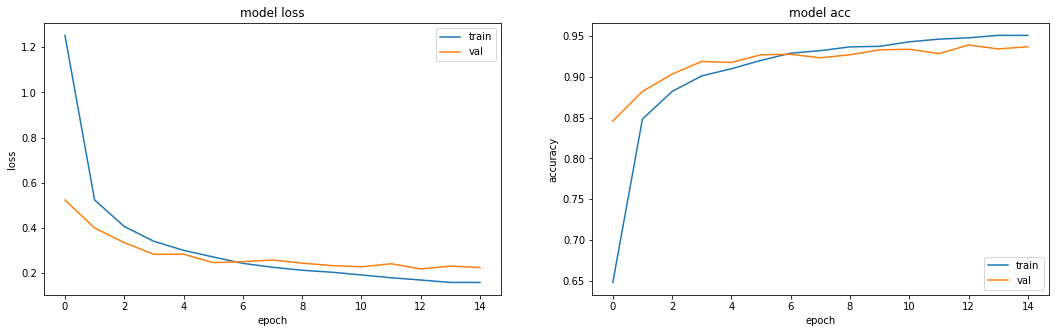

In [ ]:
plot_training_history(loss_rec1)

In [ ]:
np.round(accuracy_score(y_test_, np.argmax(model_1.predict(X_test_), axis=1)), 5)

0.92977

Let's train a little longer and see whether the accuracy increases. 

In [ ]:
model_1v2 = define_model()
model_1v2.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

In [ ]:
loss_rec1v2 = model_1v2.fit(X_train_, y_train_,
                       batch_size=128,
                       epochs=17,
                       verbose=1,
                       class_weight=my_class_weights, 
                       validation_data=(X_val_, y_val_))

Train on 62309 samples, validate on 14224 samples
Epoch 1/17
62309/62309 [==============================] - 18s 295us/sample - loss: 1.1989 - acc: 0.6627 - val_loss: 0.5464 - val_acc: 0.8379
Epoch 2/17
62309/62309 [==============================] - 16s 263us/sample - loss: 0.4973 - acc: 0.8565 - val_loss: 0.3727 - val_acc: 0.8917
Epoch 3/17
62309/62309 [==============================] - 16s 262us/sample - loss: 0.3785 - acc: 0.8898 - val_loss: 0.3069 - val_acc: 0.9090
Epoch 4/17
62309/62309 [==============================] - 16s 258us/sample - loss: 0.3233 - acc: 0.9065 - val_loss: 0.2849 - val_acc: 0.9170
Epoch 5/17
62309/62309 [==============================] - 16s 258us/sample - loss: 0.2797 - acc: 0.9188 - val_loss: 0.2622 - val_acc: 0.9237
Epoch 6/17
62309/62309 [==============================] - 16s 258us/sample - loss: 0.2538 - acc: 0.9243 - val_loss: 0.2479 - val_acc: 0.9280
Epoch 7/17
62309/62309 [==============================] - 16s 258us/sample - loss: 0.2324 - acc: 0.9314 

In [ ]:
np.round(accuracy_score(y_test_, np.argmax(model_1v2.predict(X_test_), axis=1)), 5)

0.93384

### 5. Synthetic data

My purpose of generating synthetic data is that I want to see whether including the generated data for training improves the model's generalizability on the validation (and on the test dataset).
I and my ML team at my university found 'Time masking' and 'Channel masking' significant in improving model's generalizability (when using convnet)

In [ ]:
methods = ['mag_warp', 'slice', 'time_mask', 'channel_mask']
models, scores, Y_PRED = train_on_synthetic_data(methods)

> Generating data: mag_warp
> Fitting model
> Predicting

> Generating data: slice
> Fitting model
> Predicting

> Generating data: time_mask
> Fitting model
> Predicting

> Generating data: channel_mask
> Fitting model
> Predicting



In [ ]:
pd.DataFrame({'DA':methods, 'Test Acc':scores})

,DA,Test Acc
0,mag_warp,0.93581
1,slice,0.93834
2,time_mask,0.93630
3,channel_mask,0.93933


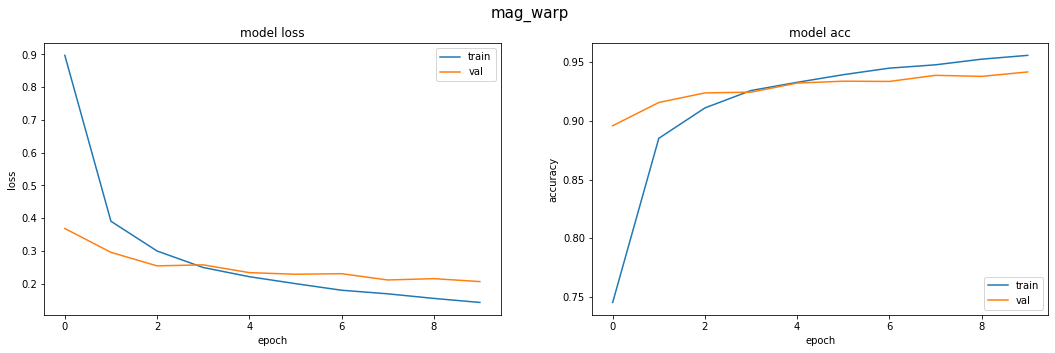

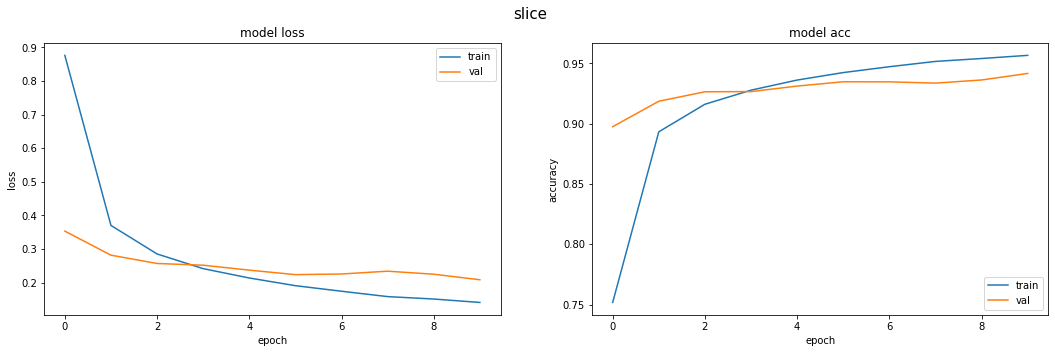

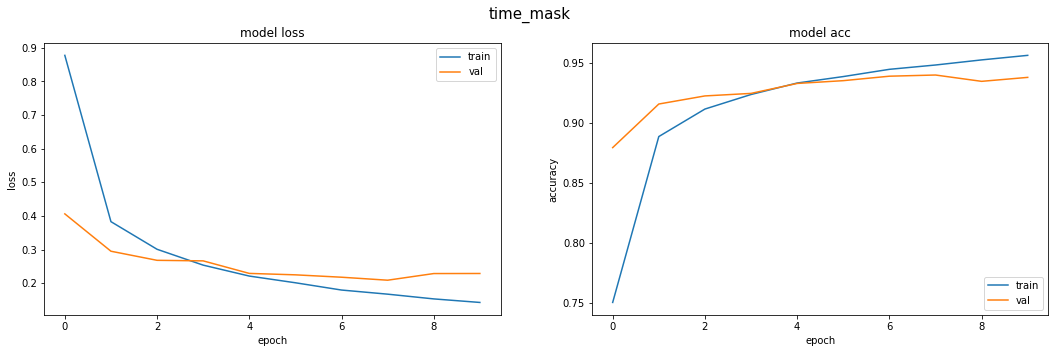

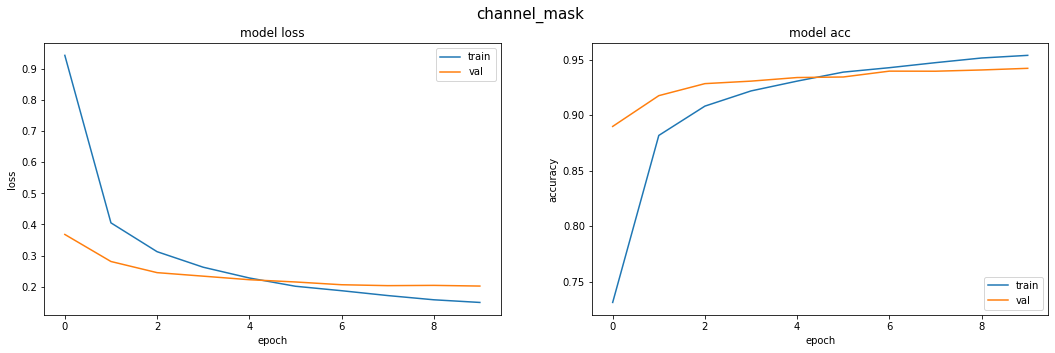

In [ ]:
for i in range(4):
    plot_training_history(models[i], methods[i])

Having multiple confution matrices clearly demonstrates each of your model's weaknesses and this allows us to, for example, 
 1. Adjust class weight (tell models to pay more attention to classes that they often make mistakes)
 2. Choose data augmentation strategies to use
 3. Choose candidate models for ensemble or stacking

#### Trying all data augmentation together

In [ ]:
X_train_aug = np.concatenate([X_train_,
                              Augment(X_train_, 'mag_warp'),
                              Augment(X_train_, 'slice'),
                              Augment(X_train_, 'time_mask'),
                              Augment(X_train_, 'channel_mask')])

y_train_aug = np.concatenate([y_train_,
                              y_train_,
                              y_train_,
                              y_train_,
                              y_train_])

shuffle_mask = shuffle_index(X_train_aug)

X_train_aug = X_train_aug[shuffle_mask]
y_train_aug = y_train_aug[shuffle_mask]

In [ ]:
model_all_da = define_model()
model_all_da.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

In [ ]:
loss_all_da = model_all_da.fit(X_train_aug, y_train_aug,
                       batch_size=128,
                       epochs=10,
                       verbose=1,
                       class_weight=my_class_weights, 
                       validation_data=(X_val_, y_val_))

Train on 311545 samples, validate on 14224 samples
Epoch 1/10
311545/311545 [==============================] - 77s 246us/sample - loss: 0.5931 - acc: 0.8298 - val_loss: 0.2574 - val_acc: 0.9266
Epoch 2/10
311545/311545 [==============================] - 74s 239us/sample - loss: 0.2720 - acc: 0.9193 - val_loss: 0.2105 - val_acc: 0.9386
Epoch 3/10
311545/311545 [==============================] - 74s 239us/sample - loss: 0.2112 - acc: 0.9366 - val_loss: 0.2051 - val_acc: 0.9414
Epoch 4/10
311545/311545 [==============================] - 74s 239us/sample - loss: 0.1815 - acc: 0.9452 - val_loss: 0.2060 - val_acc: 0.9400
Epoch 5/10
311545/311545 [==============================] - 74s 239us/sample - loss: 0.1587 - acc: 0.9517 - val_loss: 0.2069 - val_acc: 0.9435
Epoch 6/10
311545/311545 [==============================] - 74s 238us/sample - loss: 0.1424 - acc: 0.9565 - val_loss: 0.2126 - val_acc: 0.9420
Epoch 7/10
311545/311545 [==============================] - 74s 238us/sample - loss: 0.1320

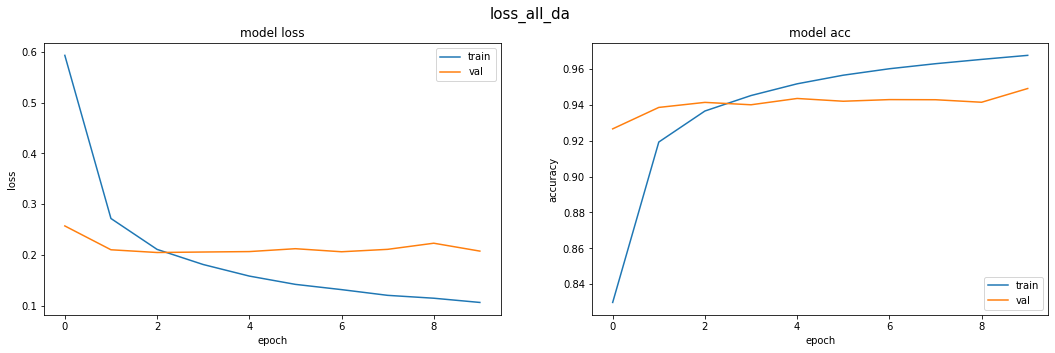

In [ ]:
plot_training_history(loss_all_da, 'loss_all_da')

Text(0.5, 1, 'all_DA')

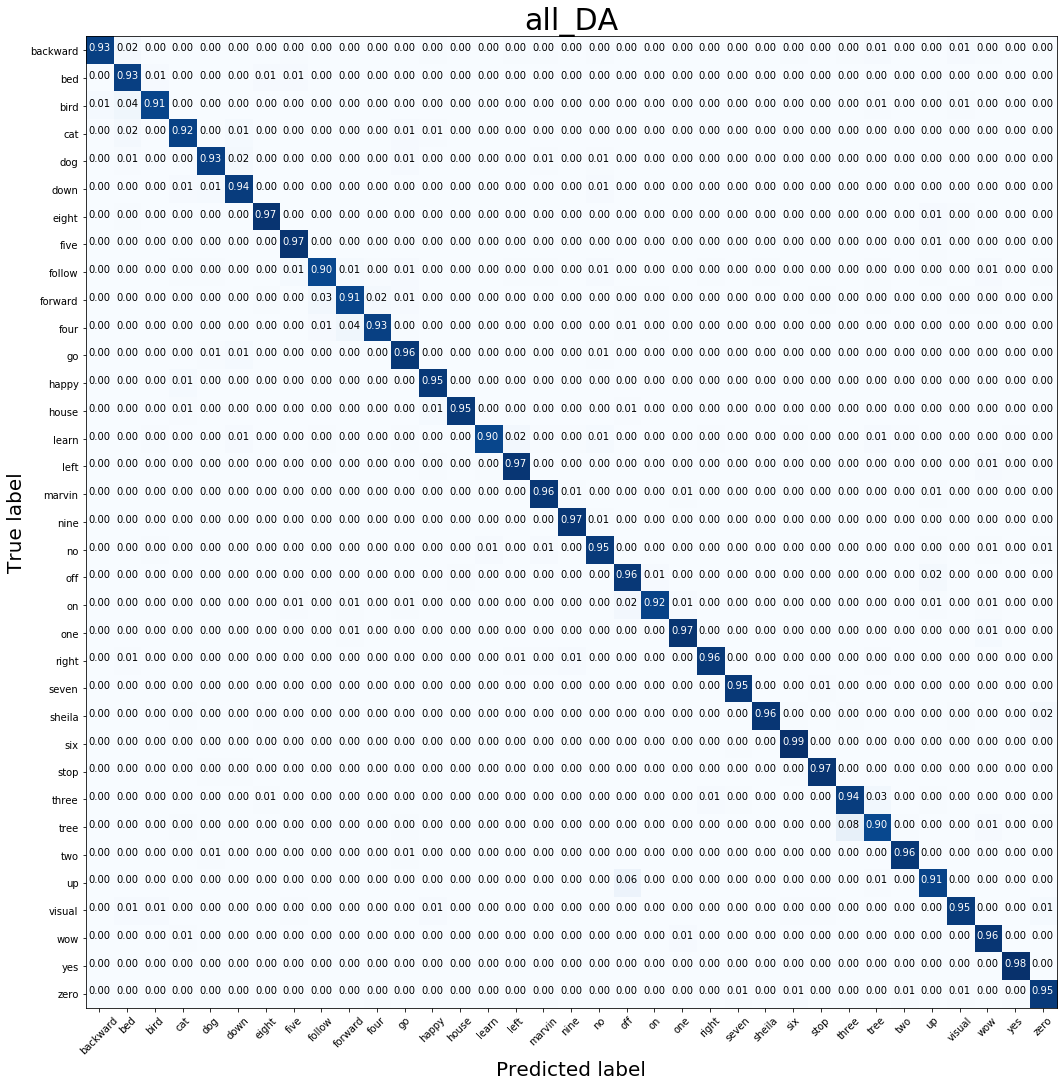

In [ ]:
# Confusion matrix y_val vs pred(X_val_)
y_pred_word = To_word(np.argmax(model_all_da.predict(X_val_), axis=1), class_dict)
cnf_matrix = confusion_matrix(y_val,
                          y_pred_word,
                          labels=list(class_dict.keys()))

plt.figure(figsize=(20,15))
plot_confusion_matrix(cnf_matrix,
                  classes=list(class_dict.keys()),
                  normalize=True)
plt.title('all_DA', fontsize=30)

In [ ]:
# Test accuracy from all_DA
np.round(accuracy_score(y_test_, np.argmax(model_all_da.predict(X_test_), axis=1)), 5)

0.94748

- Other Data Augmentation methods [here](https://arxiv.org/pdf/2004.08780.pdf).
- Codes for implementation on Python [here](https://www.slideshare.net/DonghyeonKim7/data-augmentation-for-1d).
- More about how to handle imbalanced datasets [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets).